## Analysis for Physically Implausible Decay of Diffusion Signals (PIDS)

In [24]:
import os
import mat73
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import PIDS_functions as pf
import skimage
from skimage import morphology
import cv2

In [82]:
# Change the following line for a new case
data_address = 'C://Users//Gundogdu//Desktop//University of Chicago//PATIENT_DATA//IRB17//pat083//master.mat'
data_address2 = 'C://Users//Gundogdu//Desktop//University of Chicago//PATIENT_DATA//IRB17//pat083//master3.mat'

In [84]:
print('Loading data')
try:
    data = sio.loadmat(data_address)
except NotImplementedError:
    data = mat73.loadmat(data_address)
print('Data loaded')
print('Loading data')
try:
    data2 = sio.loadmat(data_address2)
except NotImplementedError:
    data2 = mat73.loadmat(data_address2)
print('Data loaded')

Loading data


ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: string, (uint32)
ERROR:root:ERROR: MATLAB type not supported: images.roi.Freehand, (uint32)


Data loaded
Loading data
Data loaded


In [74]:
print(pf.color.BOLD + pf.color.GREEN + 'The variables in this data file are:' + pf.color.END)
for f in data.keys():
    try:
        print(f'{f} : {data[f].shape}')
    except:
        continue

The variables in this data file are:
DCE : (192, 192, 53, 60)
I : (128, 128)
I_s_rs : (128, 128)
T1 : (400, 400, 34)
T2 : (576, 576, 34)
T2_3D : (576, 576, 34)
TE : (4,)
TE_norm : (4,)
adc : (128, 128)
areScaled : ()
b : (4,)
b0 : (128, 128, 34)
b1 : (128, 128, 34, 6)
b2 : (128, 128, 34, 6)
b3 : (128, 128, 34, 12)
b4 : (128, 128, 34, 18)
bb : (4,)
benign_mask : (128, 128, 34)
bw : (128, 128)
cancer_mask : (128, 128, 34)
col : ()
hybrid_data : (128, 128, 34, 4, 4)
img2 : (128, 128, 4)
mask : (128, 128)
numSlices : ()
prostate_mask : (128, 128, 34)
raw : (128, 128, 34, 5, 3, 6)
rgbI : (128, 128, 3)
row : ()
scanned_image : (576, 576, 34)
slice : ()
val : (2,)
verified : ()


In [86]:
b_values = data['b']
TE_values = data['TE']
TE_norm = data['TE_norm']
hybrid_data = data['hybrid_data']
cancer_mask = data['cancer_mask']
benign_mask = data['benign_mask']
hybrid_raw = data['hybrid_raw']
registered_hybrid = data2['registered_hybrid']

In [78]:
hybrid_raw_reshaped = hybrid_data.copy()
for b in range(4):
    for te in range(4):
        hybrid_raw_reshaped[:, :, :, b, te] = np.mean(hybrid_raw[b][te], -1) if b else hybrid_raw[b][te]

Calculating PIDS for slice 16


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Calculating PIDS for slice 17


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Calculating PIDS for slice 18


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Calculating PIDS for slice 19


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

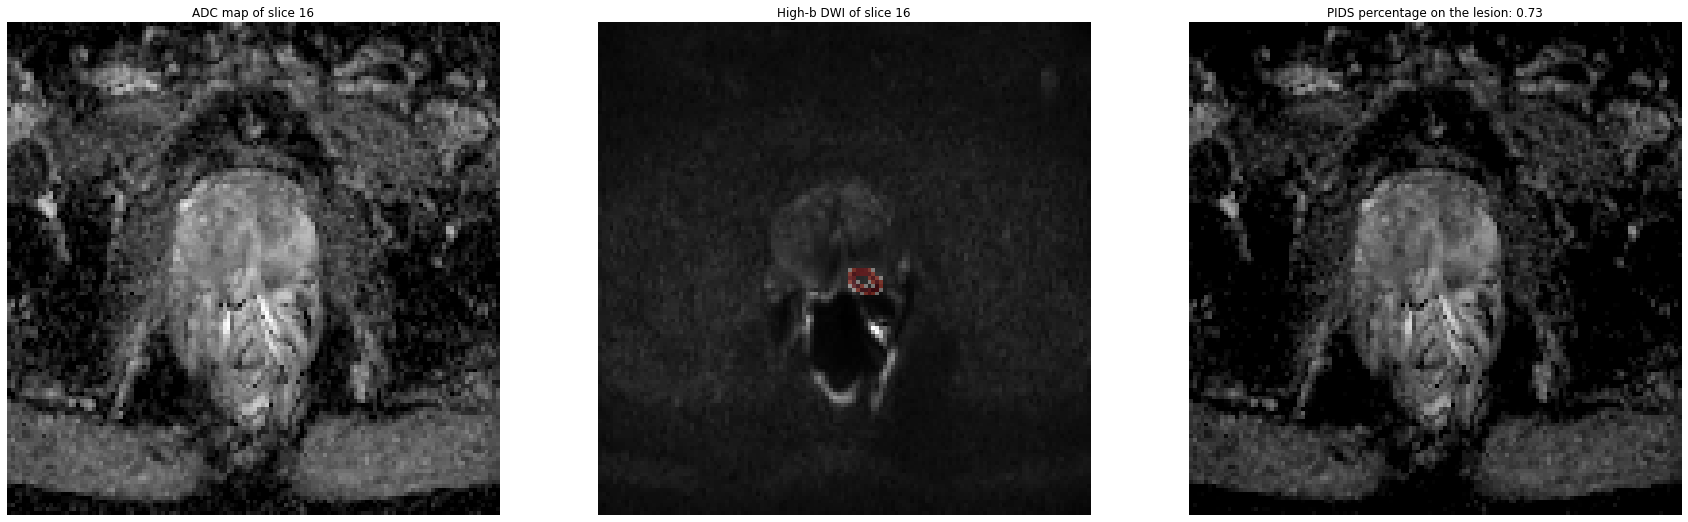

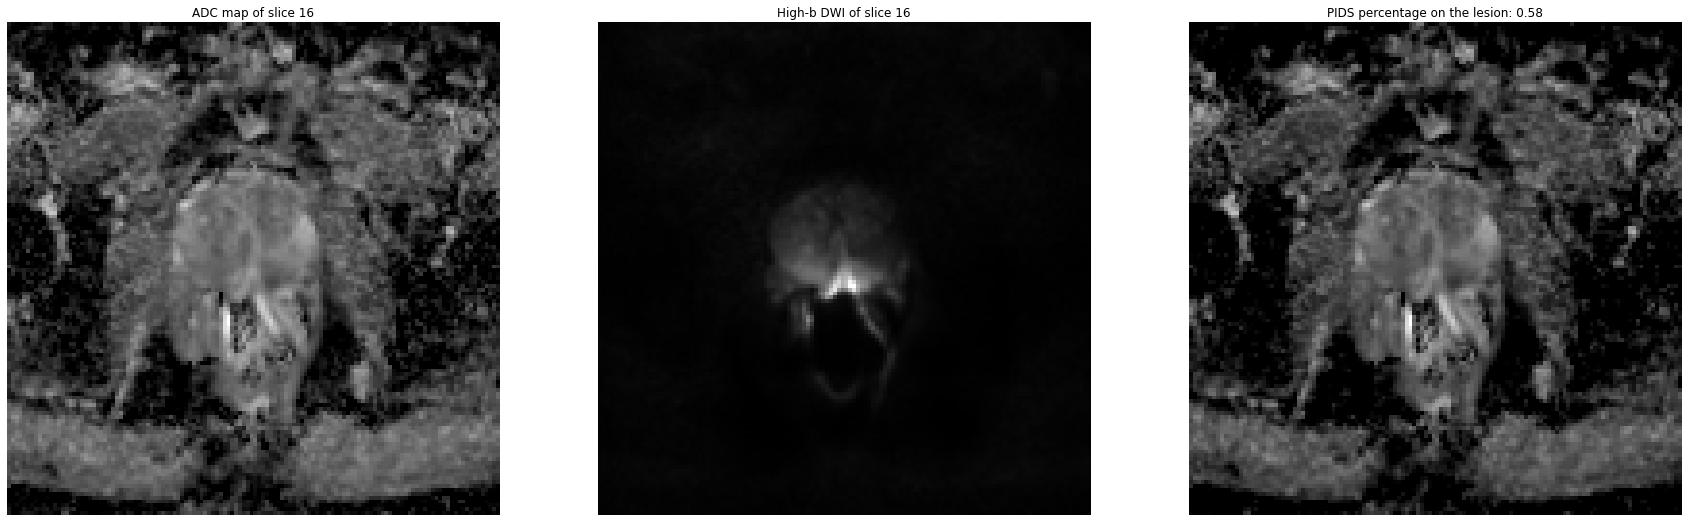

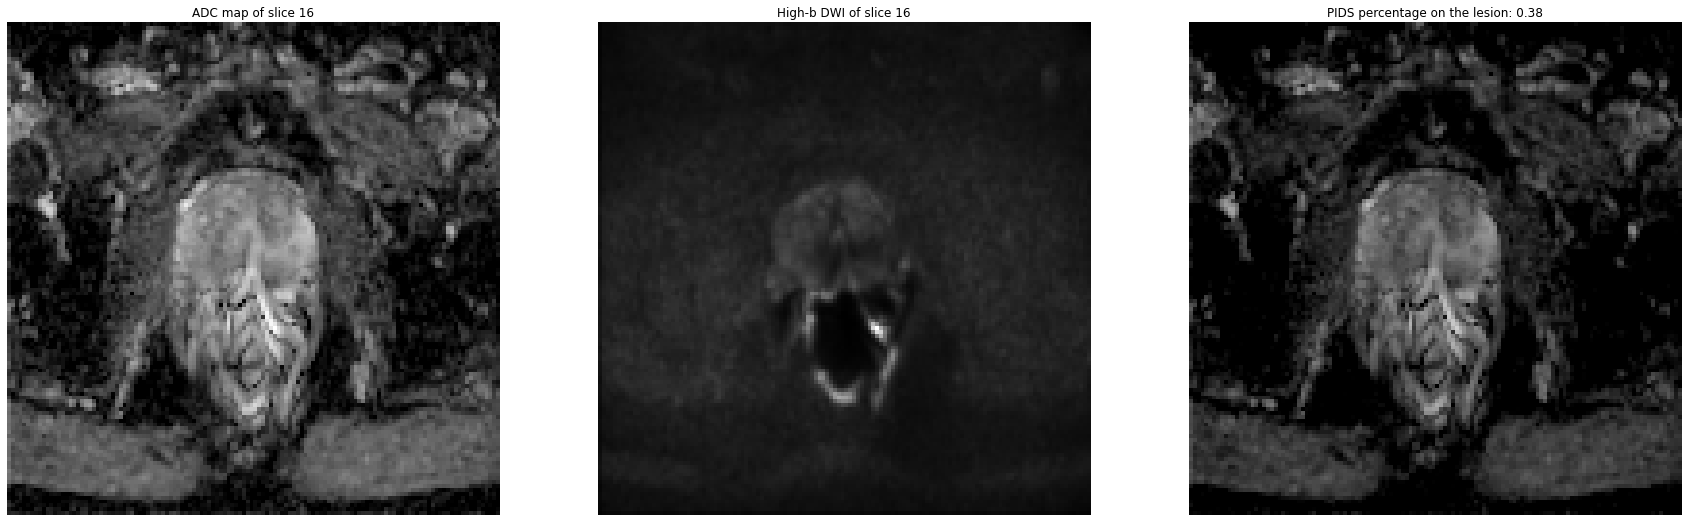

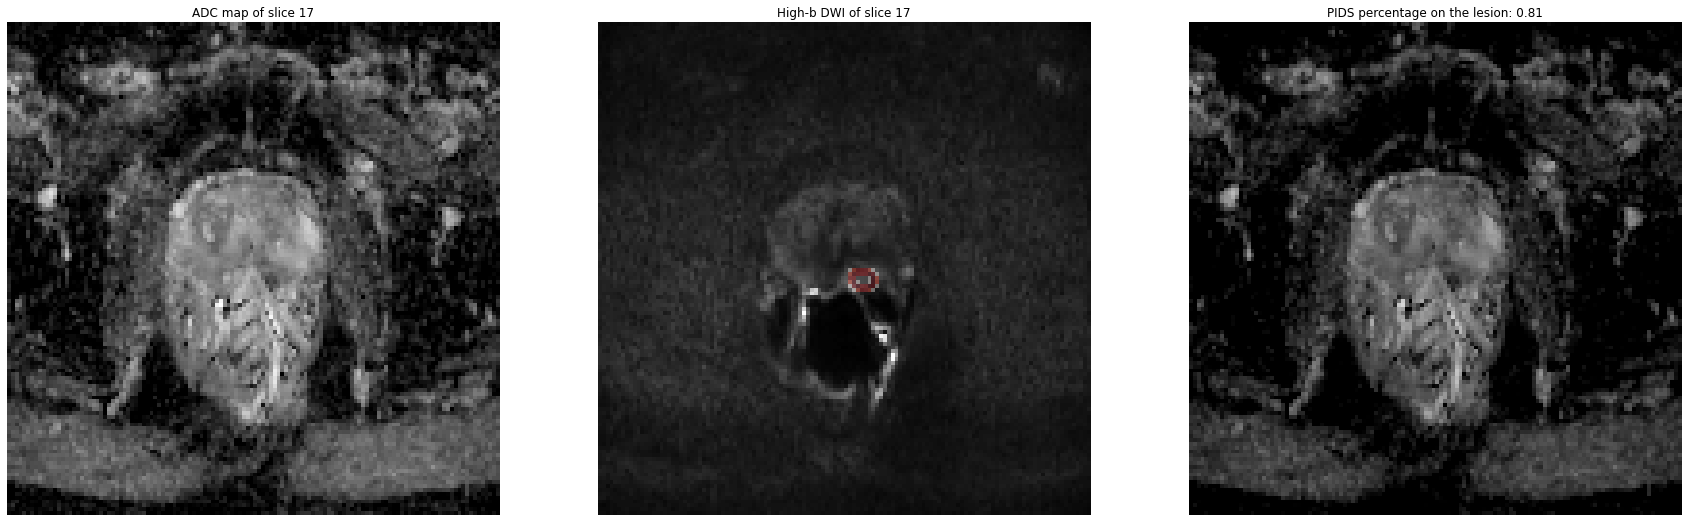

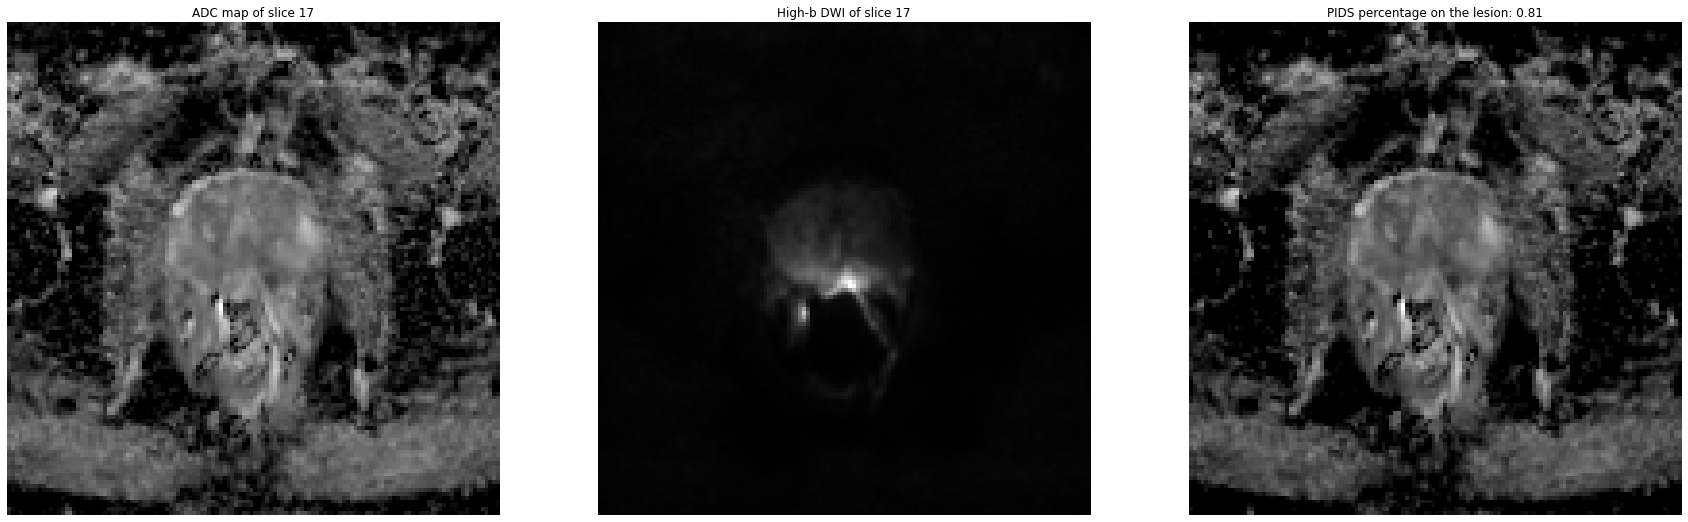

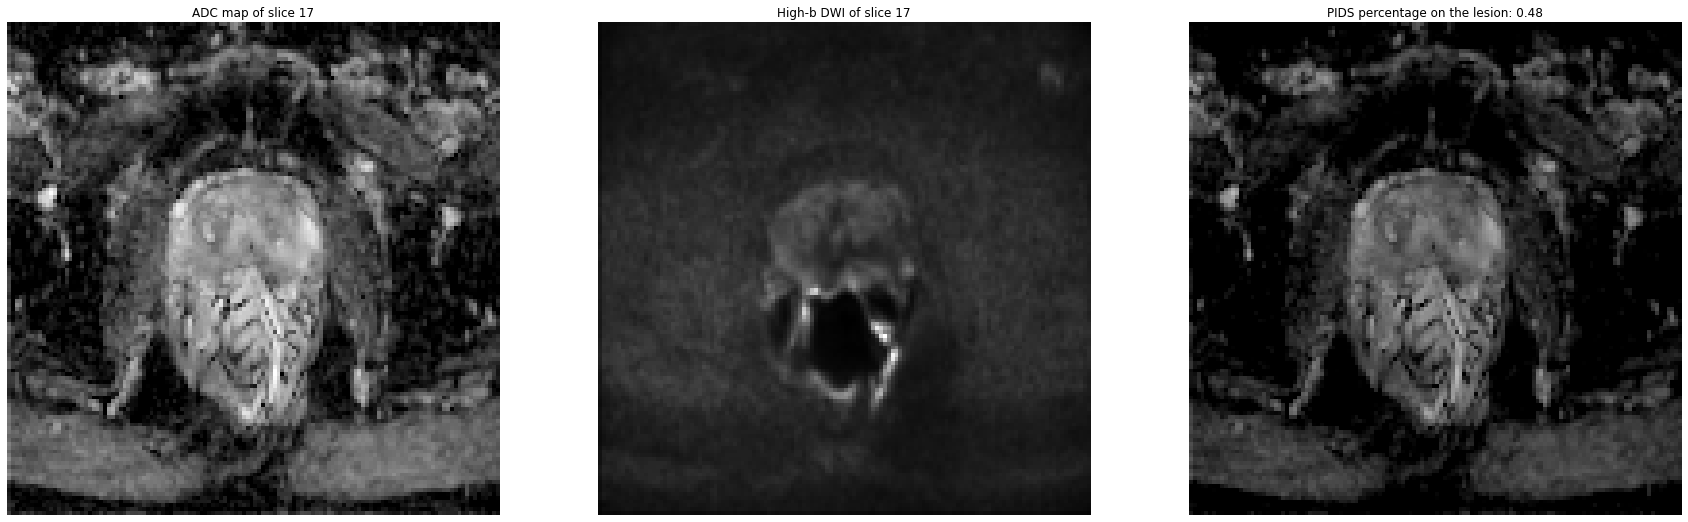

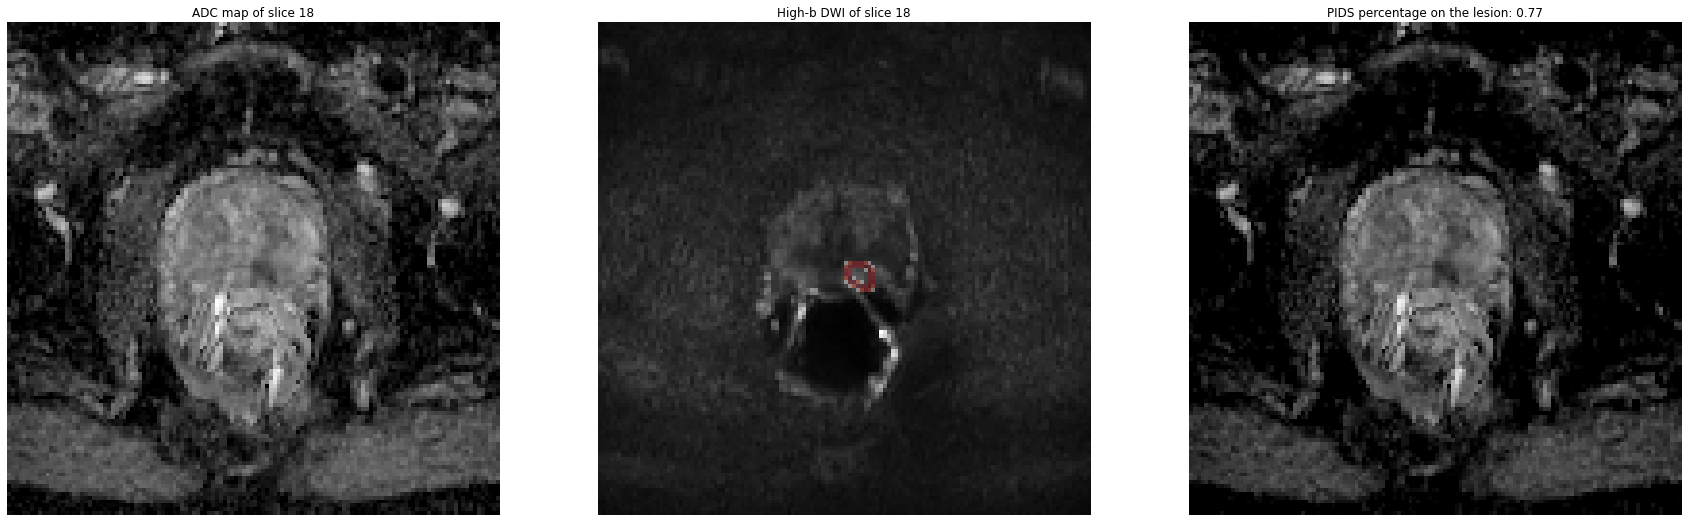

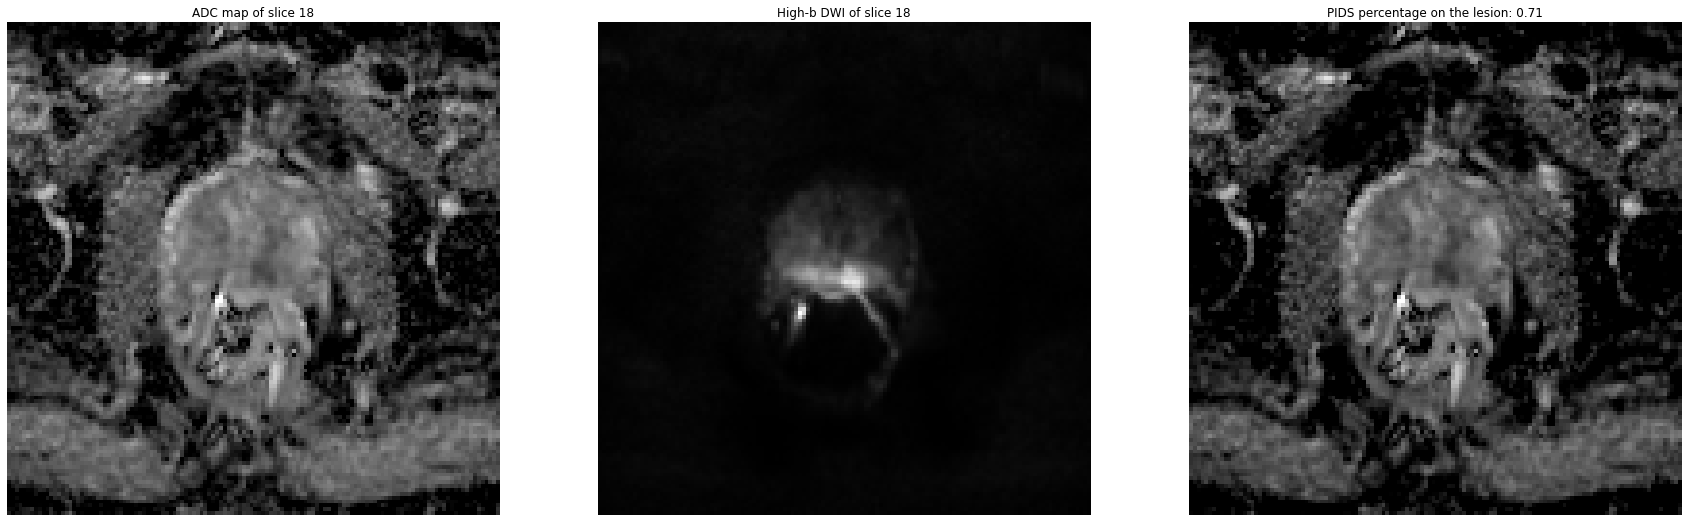

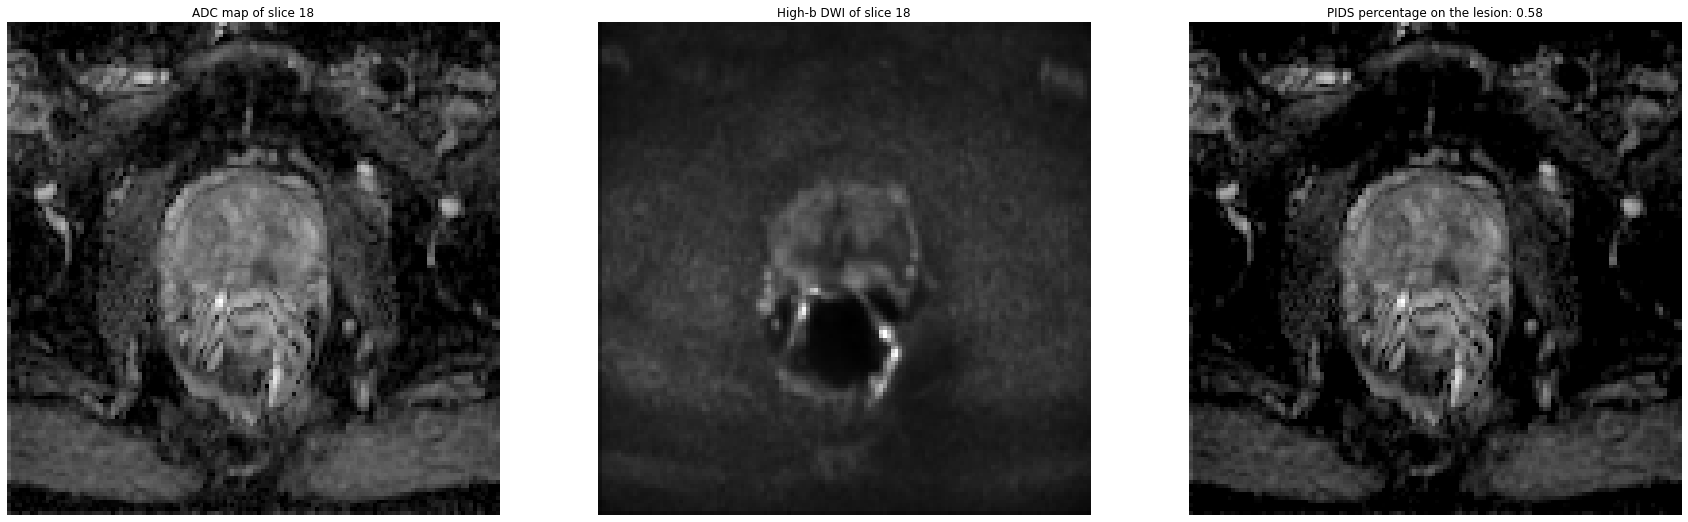

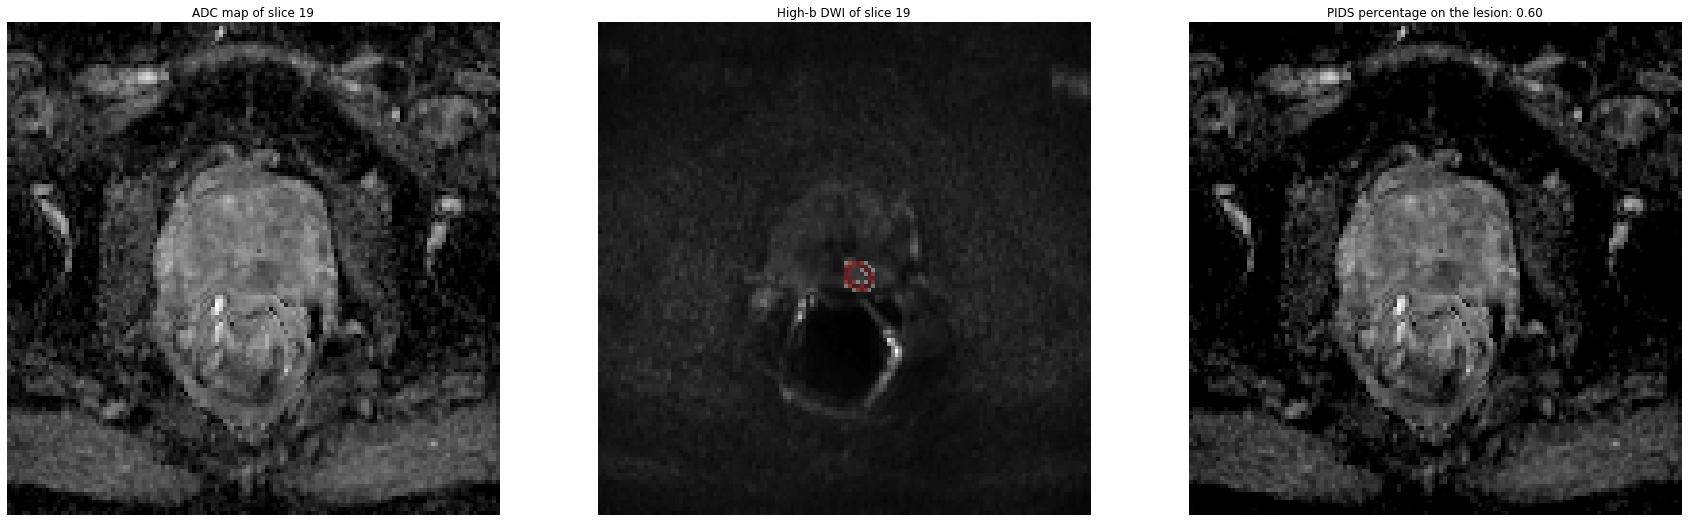

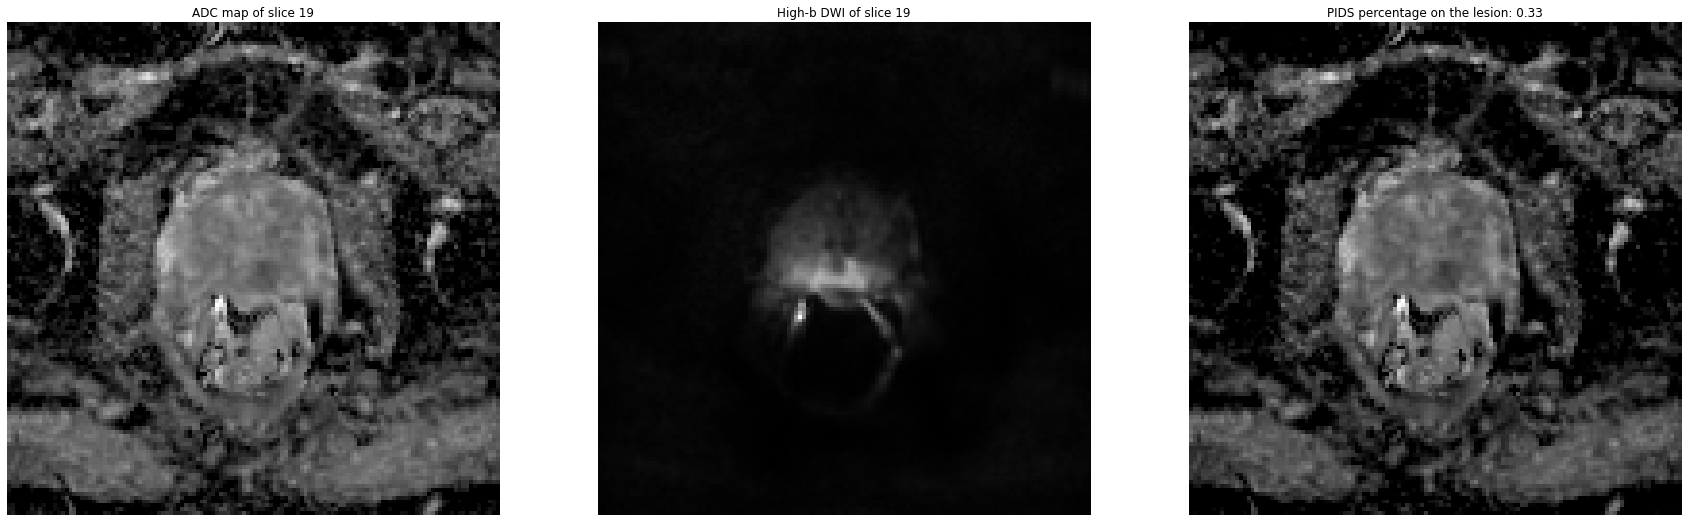

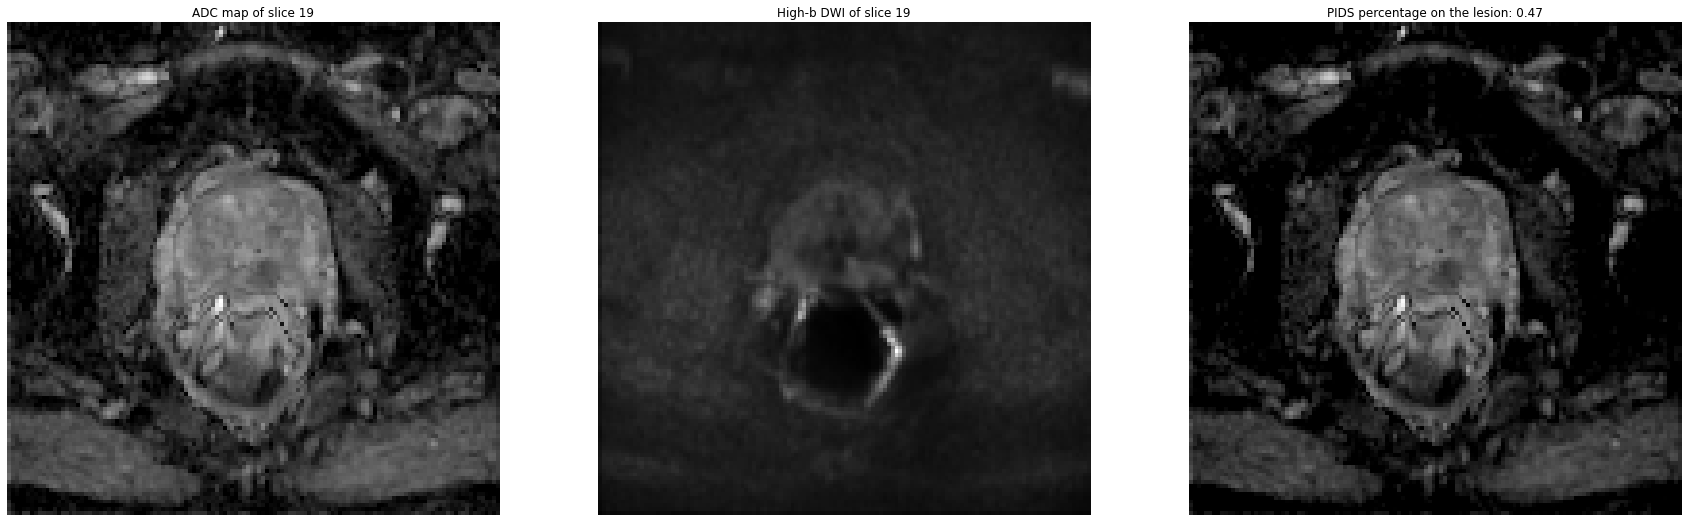

In [88]:
for sliceIndex in range(hybrid_data.shape[2]):
    if np.sum(cancer_mask[:, :, sliceIndex].flatten()):
        print(f'Calculating PIDS for slice {sliceIndex+1}')
        slicedata = np.squeeze(hybrid_data[:, :, sliceIndex, :, :])
        adc_map = pf.ADC_slice(b_values, hybrid_data[:,:, sliceIndex, :, 0])
        PIDS_1, PIDS_2, PIDS_3, PIDS_4 = pf.detect_PIDS_slice(b_values, hybrid_data[:,:, sliceIndex, :, :])
        fig, ax = plt.subplots(1,3, figsize = (30,10))
        ax[0].imshow(adc_map, cmap='gray')
        ax[0].set_title(f"ADC map of slice {sliceIndex + 1}")
        ax[0].axis('off')
        cancer = skimage.filters.sobel(cancer_mask[:, :, sliceIndex])
        cancer[cancer==0] = np.nan
        ax[0].imshow(cancer, cmap='Reds',alpha = 0.4)
        ax[0].axis('off')


        ax[1].imshow(hybrid_data[:,:, sliceIndex, 3, 0], cmap='gray')
        ax[1].set_title(f"High-b DWI of slice {sliceIndex + 1}")
        ax[1].axis('off')
        ax[1].imshow(cancer, cmap='Reds',alpha = 0.4)
        ax[1].axis('off')

        ax[2].imshow(adc_map, cmap='gray', vmin=0.3, vmax=3)
        ax[2].axis('off')

        PIDS = PIDS_1.astype(float) + PIDS_2.astype(float)
        for i in range(0,4):
            for j in range(0,3):
                PIDS += PIDS_3[:,:,i, j].astype(float)
                PIDS += PIDS_4[:,:,i, j].astype(float)
        num_cancer_voxels = cancer_mask[:, :, sliceIndex].sum()
        mask = PIDS*cancer_mask[:, :, sliceIndex]
        mask = mask.astype(float)
        num_PIDS = (mask>0).astype(float).sum()
        mask[mask==0] = np.nan
        ax[2].imshow(mask, cmap='autumn',alpha = 0.4)
        ax[2].axis('off')
        ax[2].set_title(f"PIDS percentage on the lesion: {num_PIDS/num_cancer_voxels:.2f}")

        slicedata = np.squeeze(hybrid_raw_reshaped[:, :, sliceIndex, :, :])
        adc_map = pf.ADC_slice(b_values, hybrid_raw_reshaped[:,:, sliceIndex, :, 0])
        PIDS_1, PIDS_2, PIDS_3, PIDS_4 = pf.detect_PIDS_slice(b_values, hybrid_raw_reshaped[:,:, sliceIndex, :, :])
        fig, ax = plt.subplots(1,3, figsize = (30,10))
        ax[0].imshow(adc_map, cmap='gray')
        ax[0].set_title(f"ADC map of slice {sliceIndex + 1}")
        ax[0].axis('off')
        cancer = skimage.filters.sobel(cancer_mask[:, :, sliceIndex])
        cancer[cancer==0] = np.nan
        ax[0].imshow(cancer, cmap='Reds',alpha = 0.4)
        ax[0].axis('off')


        ax[1].imshow(hybrid_raw_reshaped[:,:, sliceIndex, 3, 0], cmap='gray')
        ax[1].set_title(f"High-b DWI of slice {sliceIndex + 1}")
        ax[1].axis('off')
        ax[1].imshow(cancer, cmap='Reds',alpha = 0.4)
        ax[1].axis('off')

        ax[2].imshow(adc_map, cmap='gray', vmin=0.3, vmax=3)
        ax[2].axis('off')

        PIDS = PIDS_1.astype(float) + PIDS_2.astype(float)
        for i in range(0,4):
            for j in range(0,3):
                PIDS += PIDS_3[:,:,i, j].astype(float)
                PIDS += PIDS_4[:,:,i, j].astype(float)
        num_cancer_voxels = cancer_mask[:, :, sliceIndex].sum()
        mask = PIDS*cancer_mask[:, :, sliceIndex]
        mask = mask.astype(float)
        num_PIDS = (mask>0).astype(float).sum()
        mask[mask==0] = np.nan
        ax[2].imshow(mask, cmap='autumn',alpha = 0.4)
        ax[2].axis('off')
        ax[2].set_title(f"PIDS percentage on the lesion: {num_PIDS/num_cancer_voxels:.2f}")

        slicedata = np.squeeze(registered_hybrid[:, :, sliceIndex, :, :])
        adc_map = pf.ADC_slice(b_values, registered_hybrid[:,:, sliceIndex, :, 0])
        PIDS_1, PIDS_2, PIDS_3, PIDS_4 = pf.detect_PIDS_slice(b_values, registered_hybrid[:,:, sliceIndex, :, :])
        fig, ax = plt.subplots(1,3, figsize = (30,10))
        ax[0].imshow(adc_map, cmap='gray')
        ax[0].set_title(f"ADC map of slice {sliceIndex + 1}")
        ax[0].axis('off')
        cancer = skimage.filters.sobel(cancer_mask[:, :, sliceIndex])
        cancer[cancer==0] = np.nan
        ax[0].imshow(cancer, cmap='Reds',alpha = 0.4)
        ax[0].axis('off')


        ax[1].imshow(registered_hybrid[:,:, sliceIndex, 3, 0], cmap='gray')
        ax[1].set_title(f"High-b DWI of slice {sliceIndex + 1}")
        ax[1].axis('off')
        ax[1].imshow(cancer, cmap='Reds',alpha = 0.4)
        ax[1].axis('off')

        ax[2].imshow(adc_map, cmap='gray', vmin=0.3, vmax=3)
        ax[2].axis('off')

        PIDS = PIDS_1.astype(float) + PIDS_2.astype(float)
        for i in range(0,4):
            for j in range(0,3):
                PIDS += PIDS_3[:,:,i, j].astype(float)
                PIDS += PIDS_4[:,:,i, j].astype(float)
        num_cancer_voxels = cancer_mask[:, :, sliceIndex].sum()
        mask = PIDS*cancer_mask[:, :, sliceIndex]
        mask = mask.astype(float)
        num_PIDS = (mask>0).astype(float).sum()
        mask[mask==0] = np.nan
        ax[2].imshow(mask, cmap='autumn',alpha = 0.4)
        ax[2].axis('off')
        ax[2].set_title(f"PIDS percentage on the lesion: {num_PIDS/num_cancer_voxels:.2f}")
        

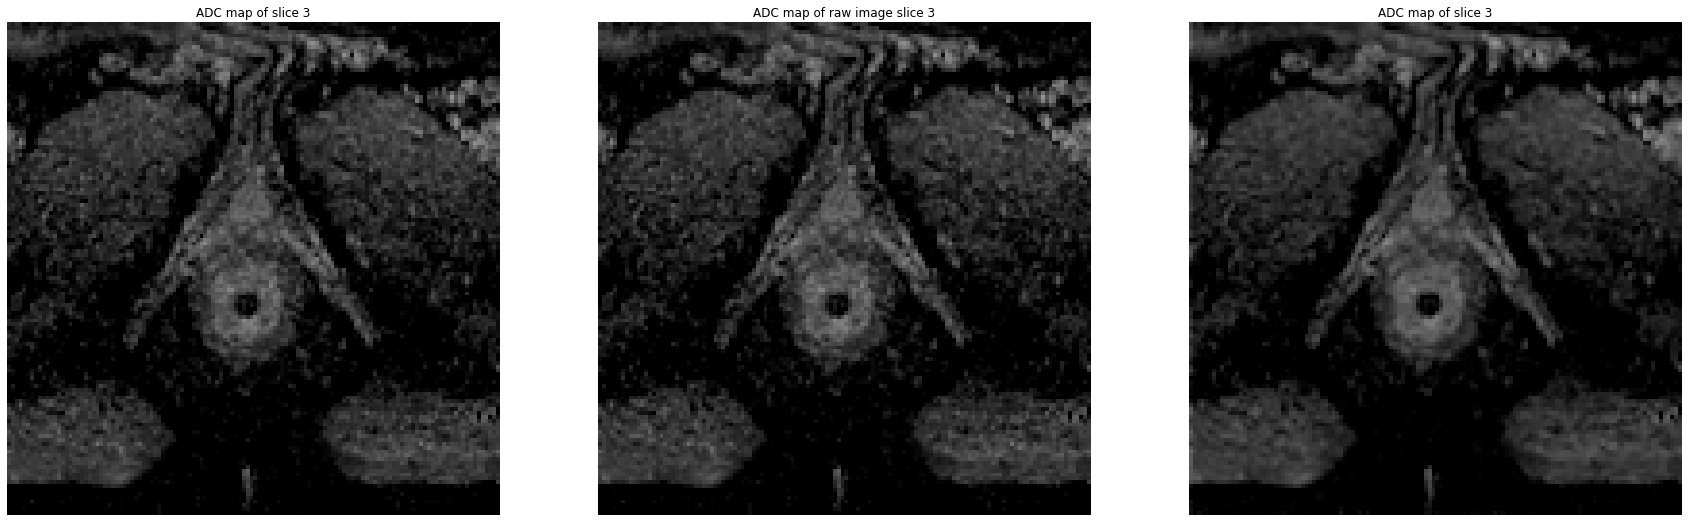

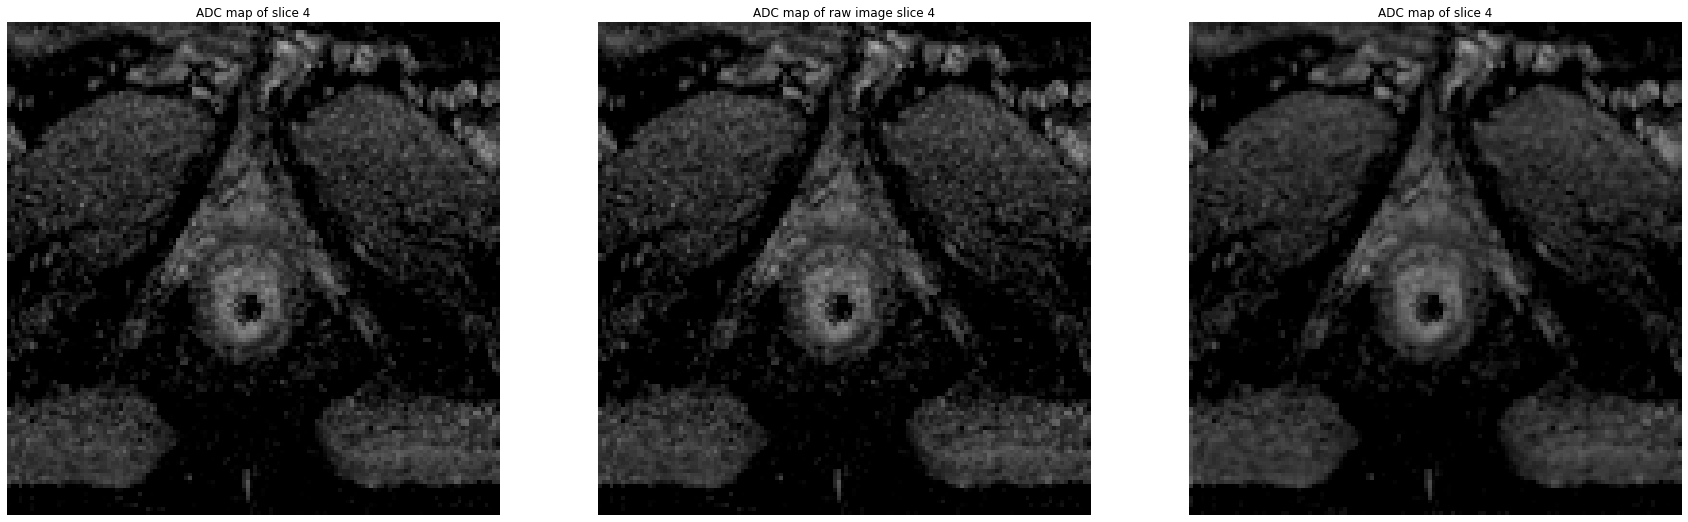

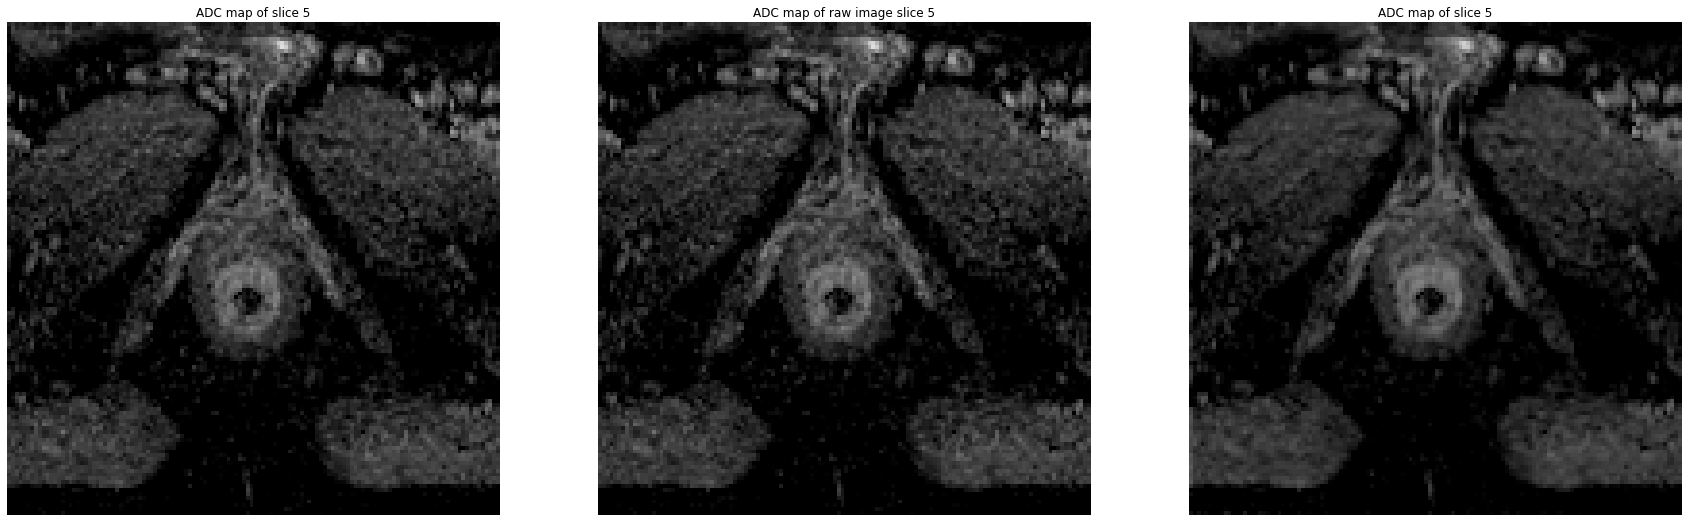

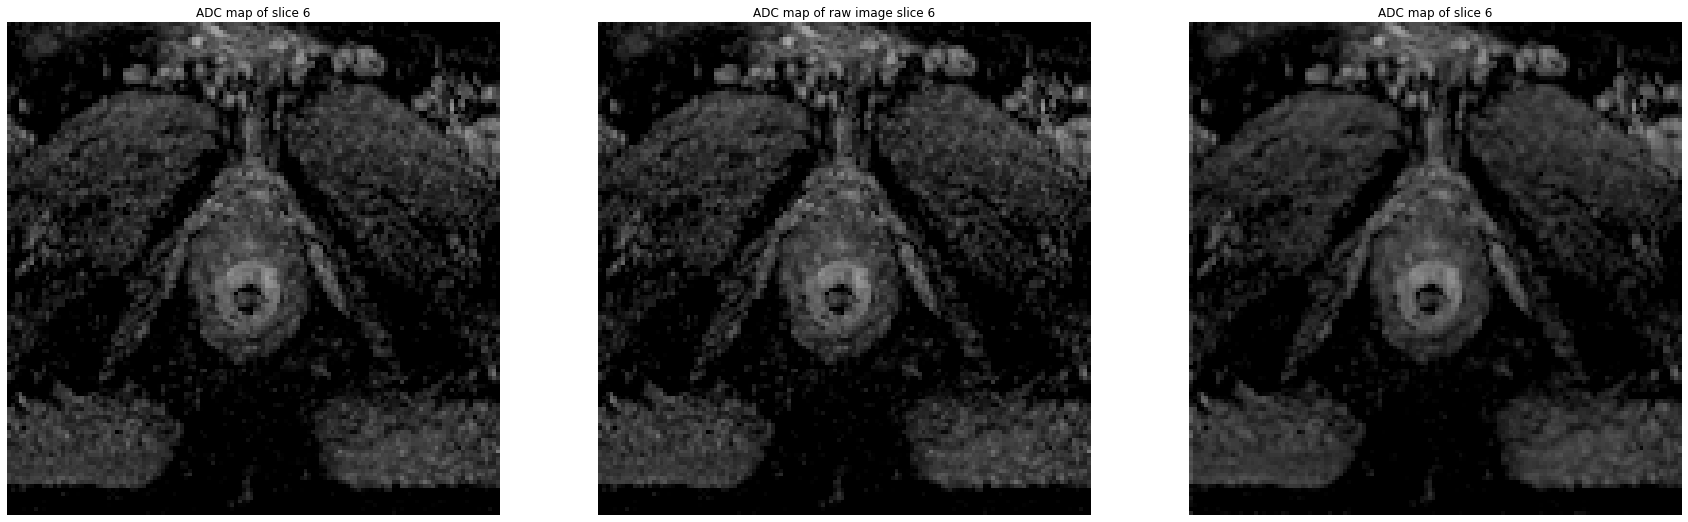

In [93]:
for sliceIndex in range(2,6):#hybrid_data.shape[2]):
    #if np.sum(cancer_mask[:, :, sliceIndex].flatten()):

    slicedata = np.squeeze(hybrid_data[:, :, sliceIndex, :, :])
    adc_map = pf.ADC_slice(b_values, hybrid_data[:,:, sliceIndex, :, 0])
    fig, ax = plt.subplots(1,3, figsize = (30,10))
    ax[0].imshow(adc_map, cmap='gray',vmin=0.3, vmax=3)
    ax[0].set_title(f"ADC map of slice {sliceIndex + 1}")
    ax[0].axis('off')
    

    #slicedata = np.squeeze(hybrid_raw_reshaped[:, :, sliceIndex, :, :])
    #adc_map = pf.ADC_slice(b_values, hybrid_raw_reshaped[:,:, sliceIndex, :, 0])
    
    
    ax[1].imshow(adc_map, cmap='gray',vmin=0.3, vmax=3)
    ax[1].set_title(f"ADC map of raw image slice {sliceIndex + 1}")
    ax[1].axis('off')
    

    slicedata = np.squeeze(registered_hybrid[:, :, sliceIndex, :, :])
    adc_map = pf.ADC_slice(b_values, registered_hybrid[:,:, sliceIndex, :, 0])
    
    ax[2].imshow(adc_map, cmap='gray',vmin=0.3, vmax=3)
    ax[2].set_title(f"ADC map of slice {sliceIndex + 1}")
    ax[2].axis('off')
        
        

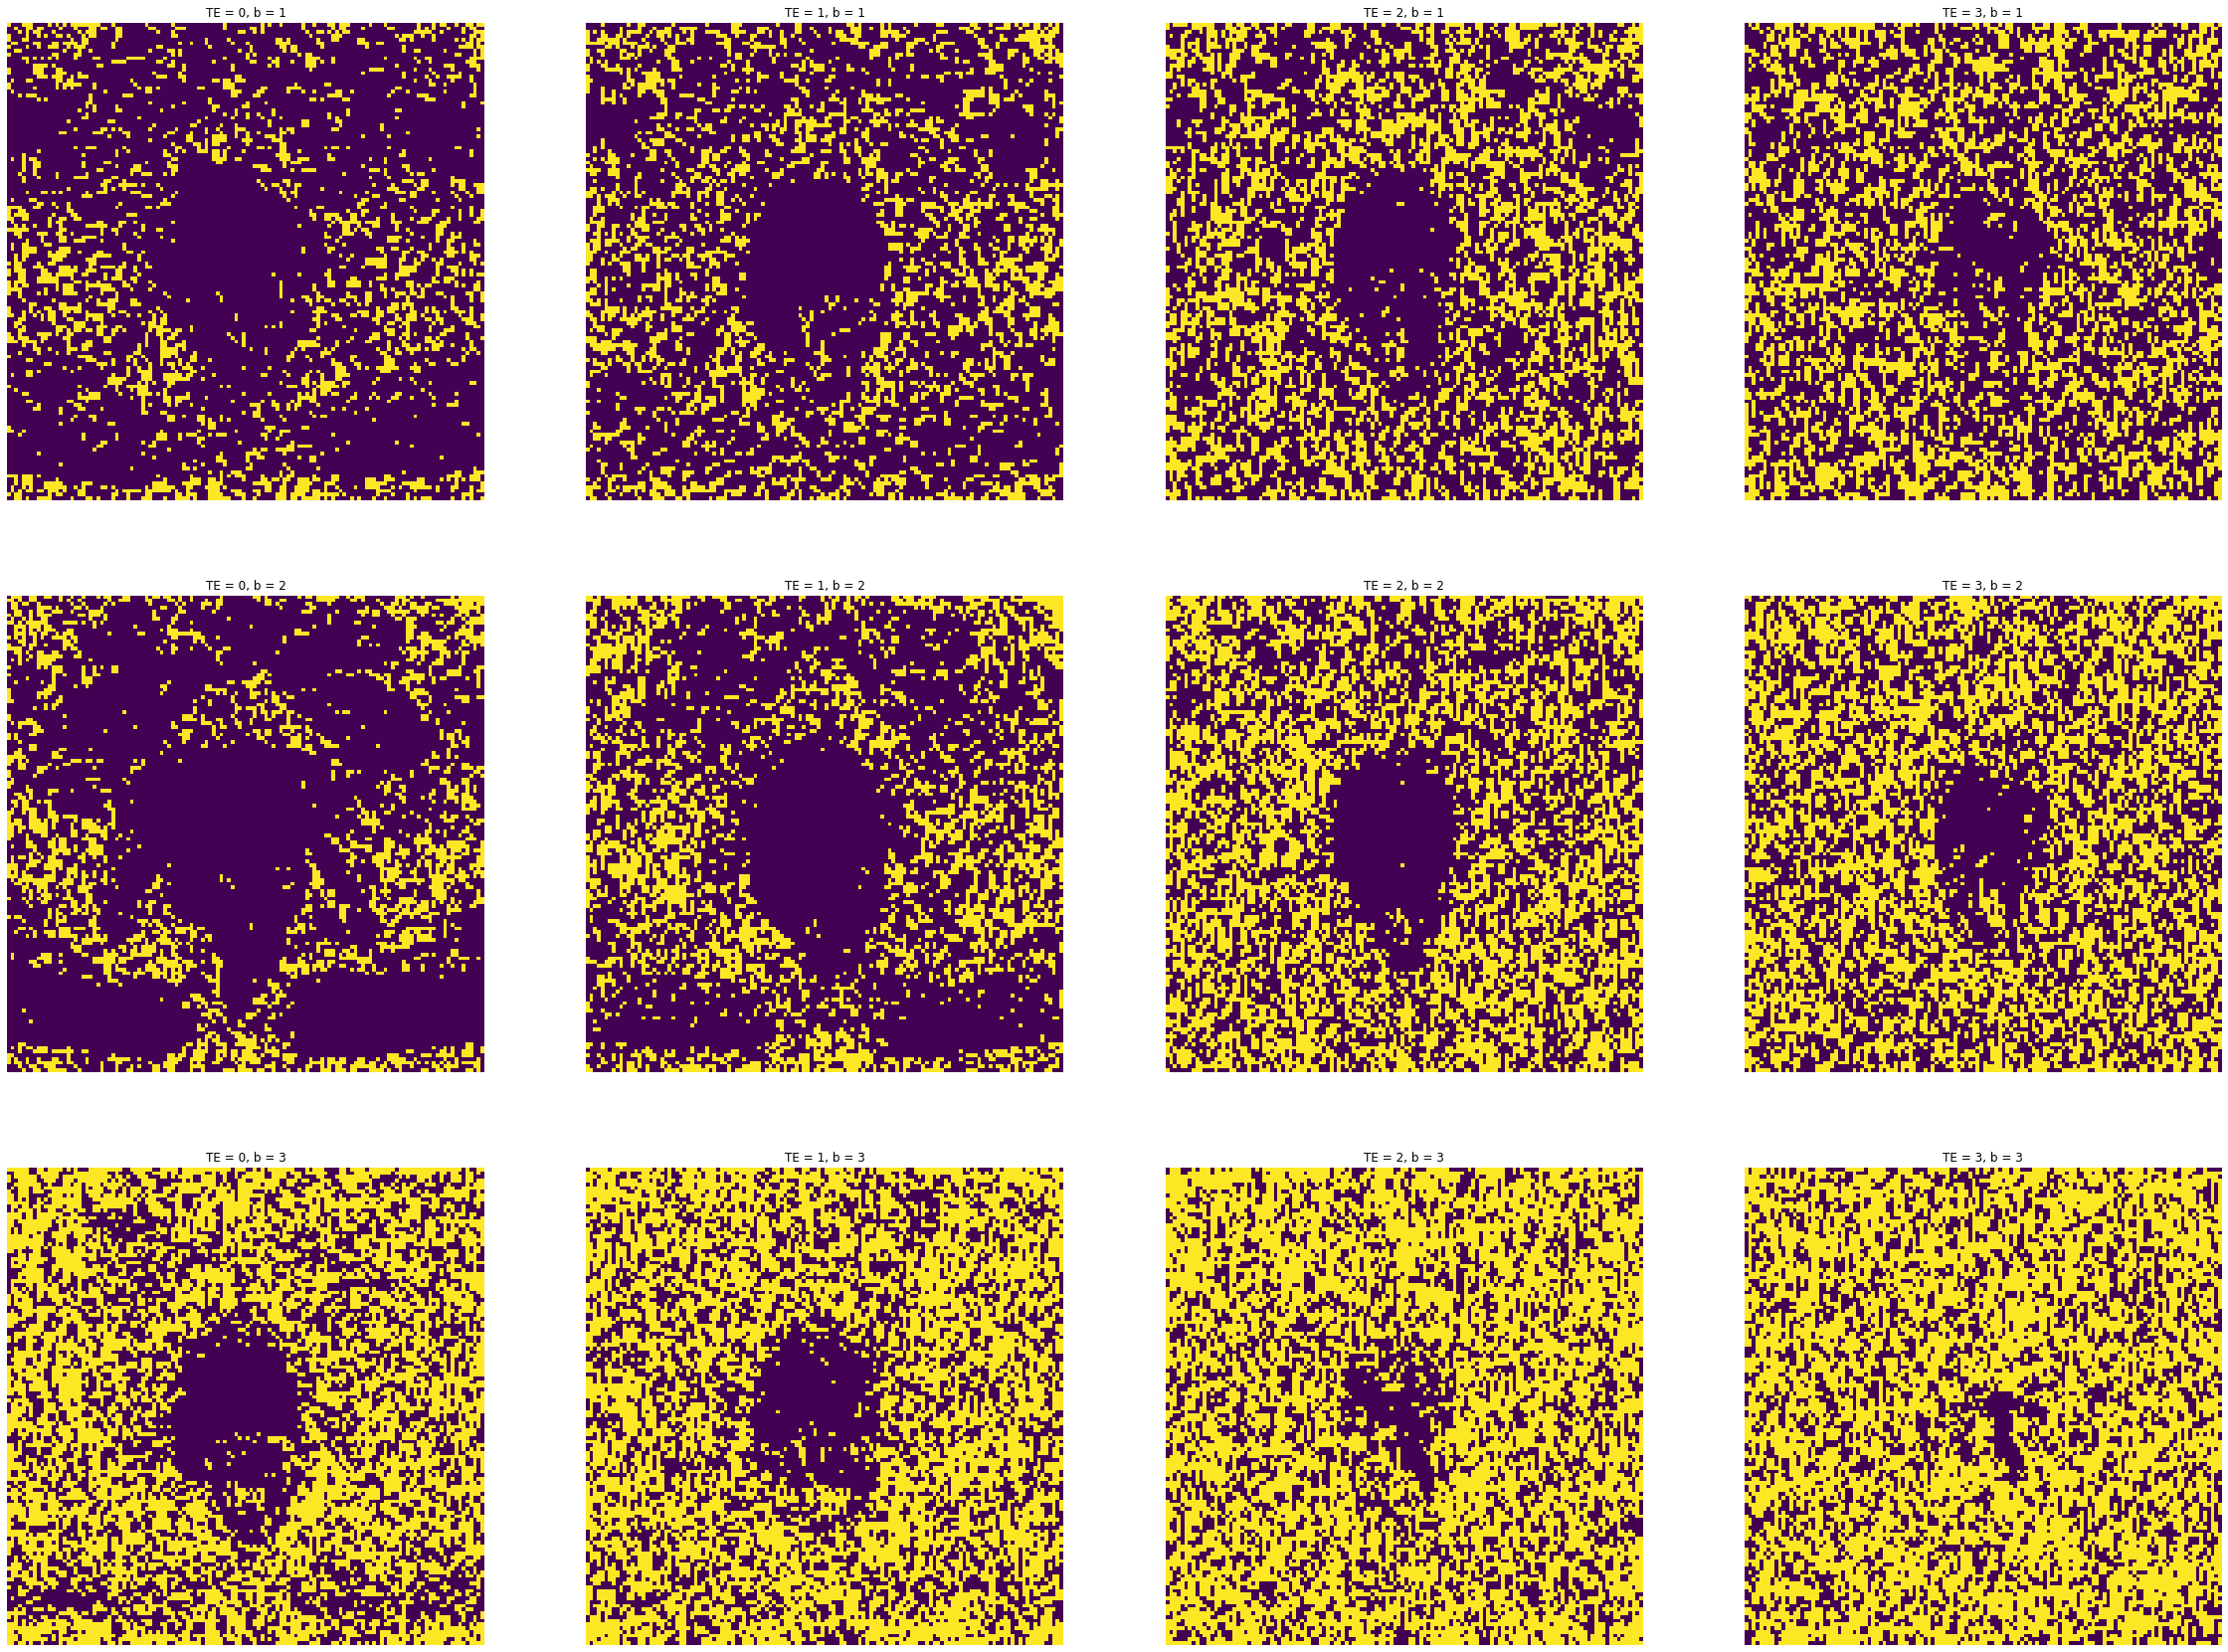

In [9]:
fig, ax = plt.subplots(3,4, figsize = (40,30))
for i in range(PIDS_3.shape[2]):
    for j in range(PIDS_3.shape[3]):
        ax[j][i].imshow(PIDS_3[:, :, i, j])
        ax[j][i].set_title(f"TE = {i}, b = {j+1}")
        ax[j][i].axis('off')


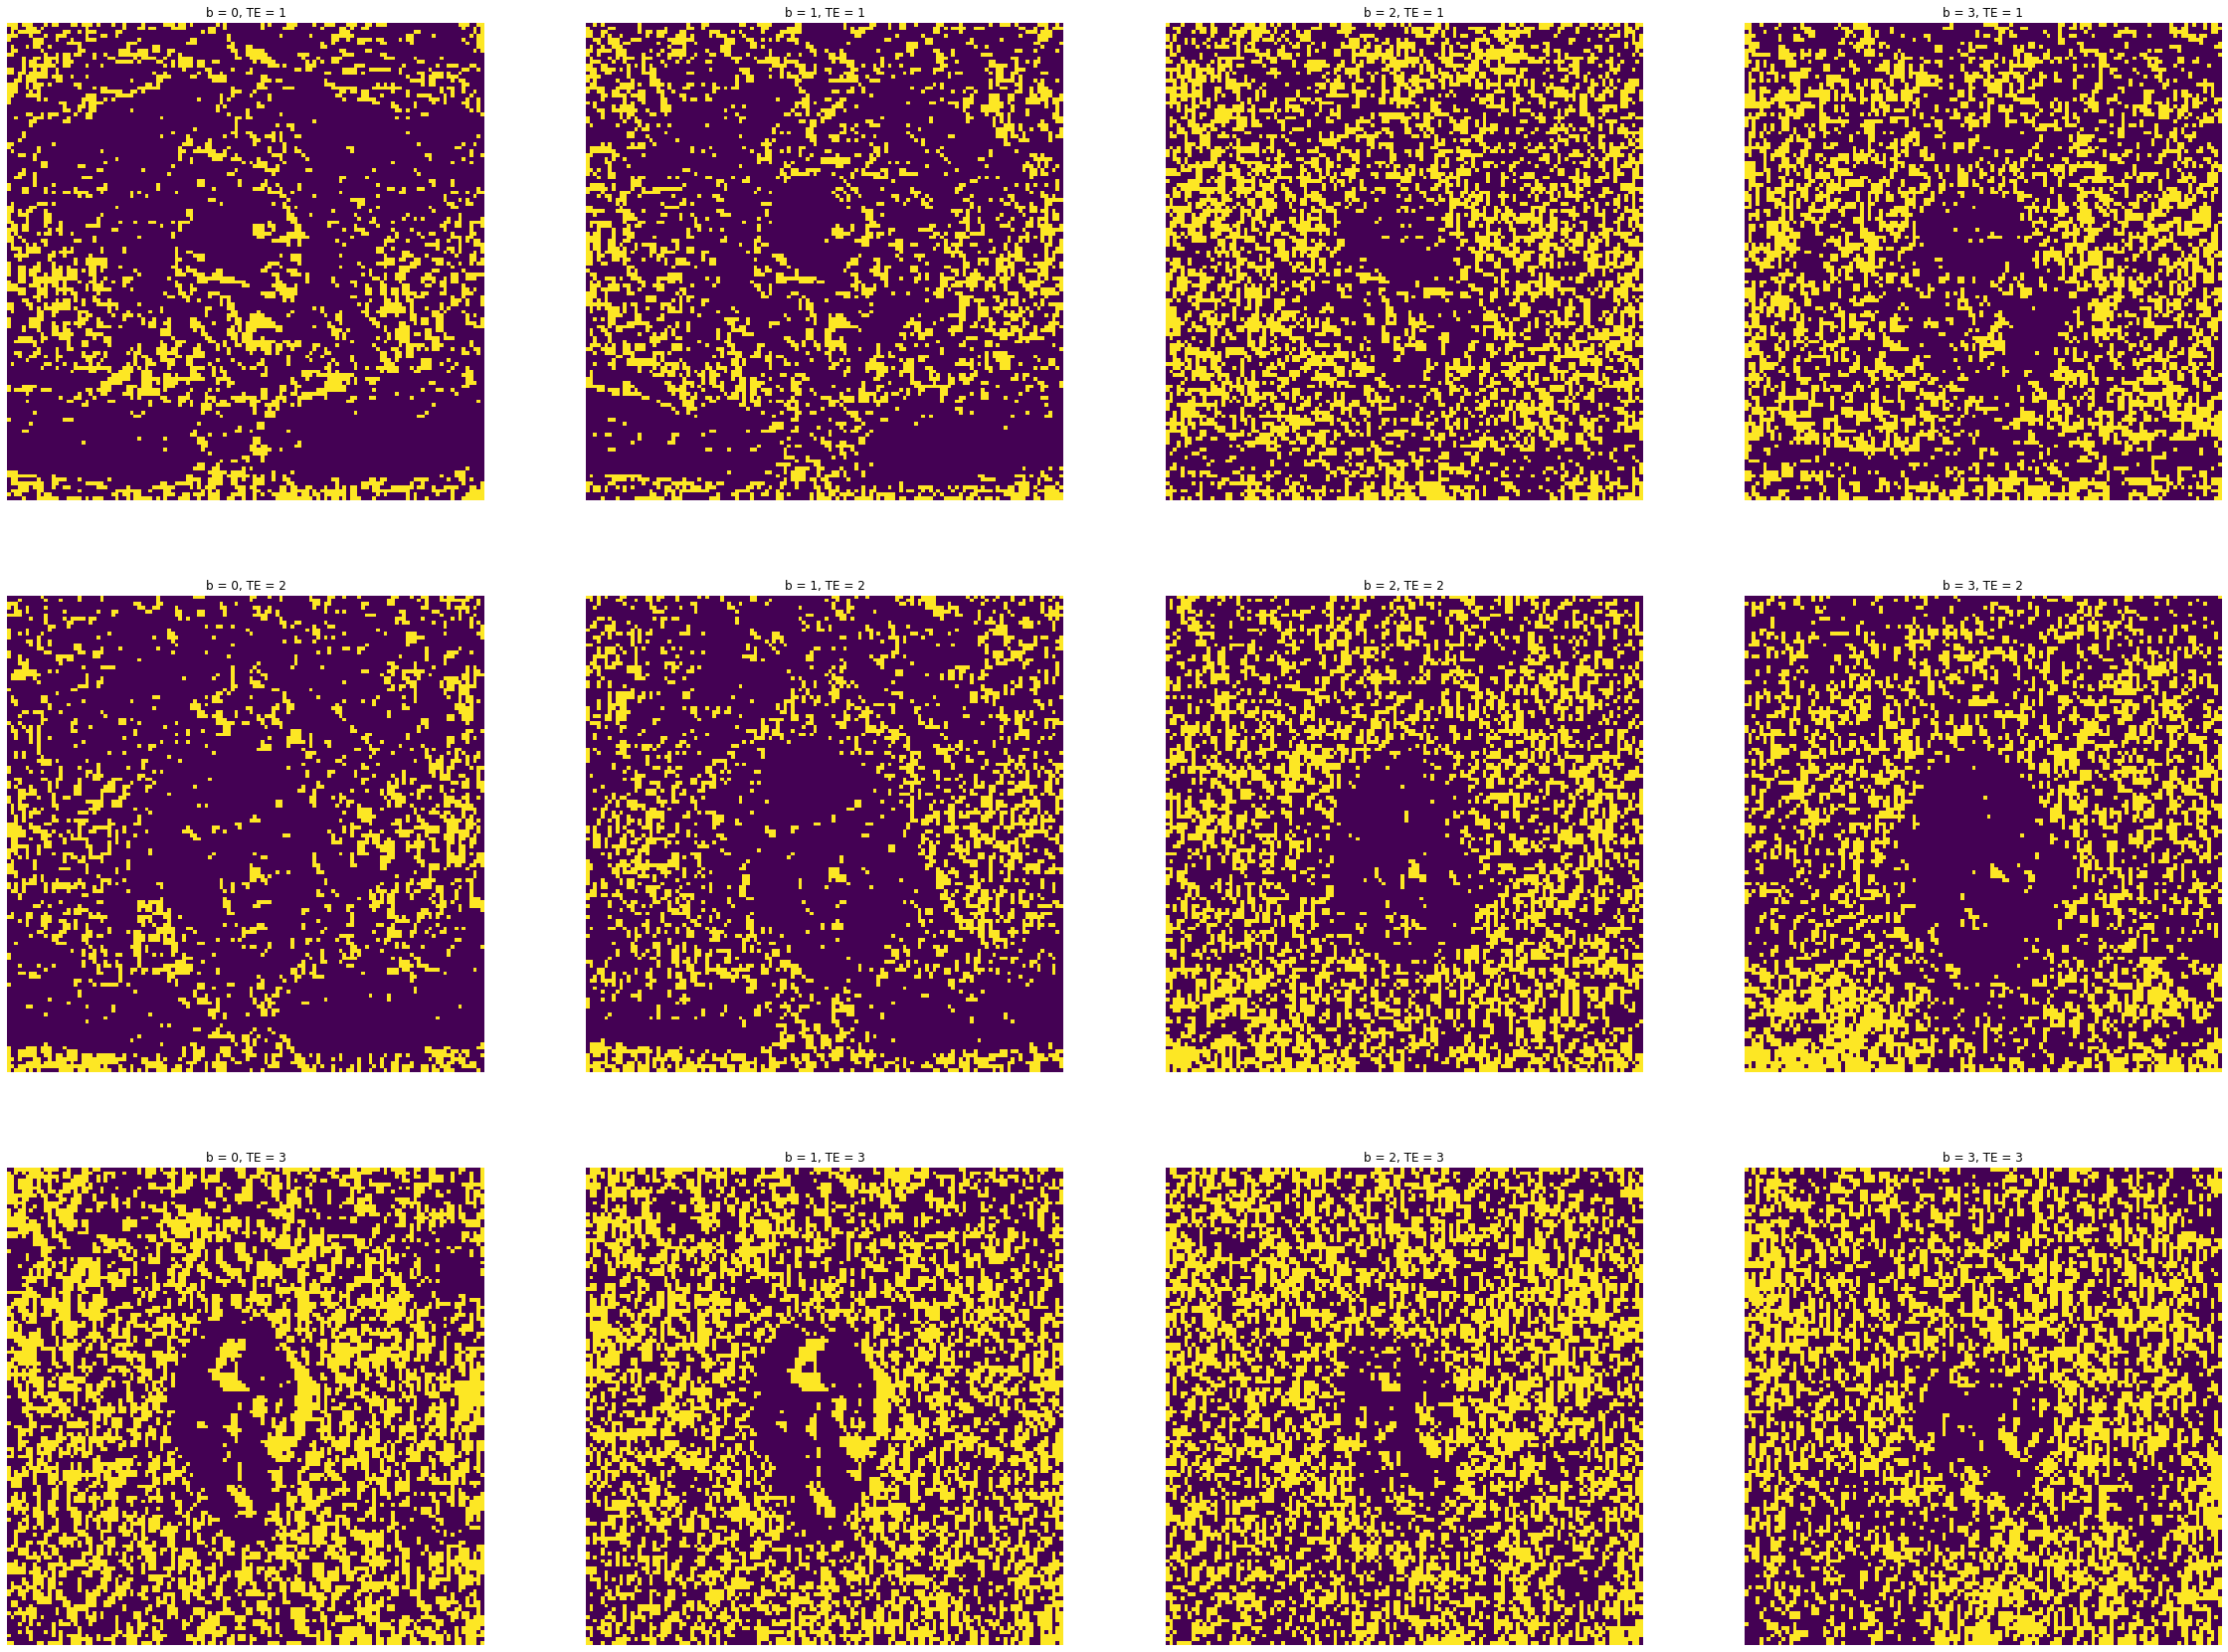

In [10]:

fig, ax = plt.subplots(3,4, figsize = (40,30))
for i in range(PIDS_4.shape[2]):
    for j in range(PIDS_4.shape[3]):
        ax[j][i].imshow(PIDS_4[:, :, i, j])
        ax[j][i].set_title(f"b = {i}, TE = {j+1}")
        ax[j][i].axis('off')

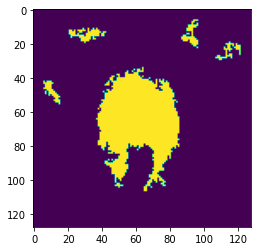

In [23]:
PIDS = PIDS_1.astype(float) + PIDS_2.astype(float)
for i in range(0,3):
     for j in range(0,2):
         PIDS += PIDS_3[:,:,i, j].astype(float)

PIDS = 1 - (PIDS>0).astype(float)
PIDS = morphology.remove_small_objects(PIDS.astype(bool), min_size=50, connectivity=50)
PIDS = morphology.remove_small_holes(PIDS, area_threshold=50, connectivity=1)
plt.imshow(PIDS)

